In [2]:
import json
import pandas as pd
import string
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"]=20,20

In [3]:
# Load data from file
filename = "data/qr62yd.json"

df = pd.read_json(filename).T
print("shape:", df.shape)
df.tail()

shape: (1640, 4)


,author,body,score,time
hk5k0pl,fsju7t32,Sorry you're having trouble.\n \nMaybe someon...,1,1636598423.0
hk5kv33,cmdd5xaa,Lol that’s all you got? Have fun bud.,1,1636598801.0
hk5l4dw,fsju7t32,I was responding to your reading trouble?\n \...,1,1636598918.0
hk5ltoi,cmdd5xaa,"Yeah, the post that made no sense.",1,1636599231.0
hk5lzo6,fsju7t32,Sorry I confused you.\n \nIs there a way I co...,1,1636599306.0


In [4]:
# Analysis setup
sia = SentimentIntensityAnalyzer()


def sentiment(comment: str):
    return sia.polarity_scores(comment)['compound']


def is_positive(comment: str):
    return sentiment(comment) > 0


def is_negative(comment):
    return sentiment(comment) < 0


def purge_punct(word):
    return "".join([c for c in word if c not in string.punctuation])


def clean(words):
    g = []
    for comment in df['words']:
        l = []
        for token in comment:
            if token.lower() not in stopwords:
                l.append(snowball.stem(
                    purge_punct(token)))
        g.append(l)
    return g

In [5]:
# Data cleanup
stopwords = nltk.corpus.stopwords.words("english") + ["get", "i", "the"]
snowball = nltk.stem.SnowballStemmer('english')

#words = [j.lower() for i in [w.split() for w in comments] for j in i]
df['words'] = [token.split() for token in df['body']]
df['cleaned'] = clean(df['words'])

words = [j for i in [w for w in df['cleaned'].tolist()] for j in i]

df.sample(5)

,author,body,score,time,words,cleaned
hk5fkz2,fy1d8,I think you'll have to pay to give him away un...,1,1636596438.0,"[I, think, you'll, have, to, pay, to, give, hi...","[think, pay, give, away, unfortun, fuck, send,..."
hk5dqkh,xmwpl,Ok ready for some game management now.,2,1636595624.0,"[Ok, ready, for, some, game, management, now.]","[ok, readi, game, manag, now]"
hk56nmx,6mqak,"Yup. Was just gonna say, dude needs to stop sh...",2,1636592467.0,"[Yup., Was, just, gonna, say,, dude, needs, to...","[yup, gonna, say, dude, need, stop, shoot, much]"
hk5j9gw,xox1ci5,Lots of players on this team that are new and ...,2,1636598082.0,"[Lots, of, players, on, this, team, that, are,...","[lot, player, team, new, bottom, six, replac, ..."
hk5e2k7,5cgz2cvm,Lol,1,1636595769.0,[Lol],[lol]


In [6]:
# Analysis Time!

# number of positive vs negative comments
pos = 0
neg = 0
neut = 0
res = []

for c in df['cleaned']:
    if is_positive(" ".join(c)):
        pos += 1
        res.append("pos")
    elif is_negative(" ".join(c)):
        neg += 1
        res.append("neg")
    else:
        neut += 1
        res.append("neut")


print("\ntotal: %d negative: %d positive: %d neutral: %d" %
      (len(df['cleaned']), neg, pos, neut))

df['sentiment'] = res
df[['body','cleaned','sentiment']].sample(10)


total: 1640 negative: 418 positive: 616 neutral: 606


,body,cleaned,sentiment
hk5g93q,"For icing, do linesmen call it icing even when...","[ice, linesmen, call, ice, even, 5050, race]",neut
hk5dysa,Refs trying REAL hard this game REAL hard,"[ref, tri, real, hard, game, real, hard]",neg
hk575h1,Missed the first little bit.. how are we looki...,"[miss, first, littl, bit, look]",neg
hk5odet,I blame you for this inevitability now,"[blame, inevit]",neg
hk567r2,"Is it just me, or has Nylander become more slo...","[me, nyland, becom, slow, late, look, like, py...",pos
hk57a2a,I think it’s cause all his features are pretty...,"[think, it, caus, featur, pretti, close, middl...",pos
hk5f91v,"Nick Ritchie is a plug, he’s that guy at your ...","[nick, ritchi, plug, he, guy, beer, leagu, one...",neut
hk5lrm8,Refs really trying to get the flyers back in t...,"[ref, realli, tri, flyer, back, one]",neut
hk59ybm,Agreed.\n\nSit Ritchie though,"[agre, sit, ritchi, though]",neut
hk5ka0b,Nice pass from Ritchie there,"[nice, pass, ritchi]",pos


In [7]:
#Words used most frequently
print(nltk.FreqDist(words).tabulate(15))

ritchi   fuck   play   like   game   goal   that    lol   good   leaf   kick   look            go   holl 
   159    138    127    120    113    109    101     94     92     84     82     80     66     64     64 
None


In [8]:
#Word combinations
item = words

bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(item)
bigram_finder.ngram_fd.tabulate(5)

trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(item)
trigram_finder.ngram_fd.tabulate(4)

quadgram_finder = nltk.collocations.QuadgramCollocationFinder.from_words(item)
quadgram_finder.ngram_fd.tabulate(3)

  ('look', 'like') ('kick', 'motion')   ('that', 'kick')   ('feel', 'like') ('nick', 'ritchi') 
                23                 19                 14                 14                 13 
  ('odd', 'man', 'rush')     ('go', 'leaf', 'go')   ('give', 'hot', 'man') ('look', 'like', 'holl') 
                       3                        3                        3                        3 
    ('it', 'review', 'relax', 'lol') ('review', 'relax', 'lol', 'happen')     ('relax', 'lol', 'happen', 'us') 
                                   3                                    3                                    3 


In [10]:
#Words in context. Should be interesting to see the result of this for a variety of words
words_of_interest = ['philly', 'flyers', 'philadelphia']

for word in words_of_interest:
    concordance = nltk.Text(words).concordance_list(snowball.stem(word), lines=None)
    print(word, ":", len(concordance), "total occurrences,", end=" ")
    pos = 0
    neg = 0
    neut = 0
    for entry in concordance:
        if is_positive(entry.line): pos += 1
        elif is_negative(entry.line): neg += 1
        else: neut += 1

    print(pos, "positive", neg, "negative", neut, "neutral")

philly : 31 total occurrences, 22 positive 8 negative 1 neutral
flyers : 31 total occurrences, 18 positive 10 negative 3 neutral
philadelphia : 4 total occurrences, 1 positive 2 negative 1 neutral


In [34]:
#Setup for Visualizations
interval = 6 * 60  # intervals of 5 minutes
types = ['pos', 'neg', 'neut']

# get the number of buckets
start = min(df['time'])
end = max(df['time'])
duration = end-start
buckets = int(np.ceil(duration / interval))

first_n = 60

# place the comments into the buckets
filtered = []
for i in range(buckets):
    filtered.append(df.loc[(df['time'] >= start + interval*(i))
                    & (df['time'] < start + interval*(i+1))])

# count the number of positive, negative and neutral comments in each bucket
sentiment = {'pos': np.array([]), 'neg': np.array([]), 'neut': np.array([])}
for bucket in filtered[:first_n]:
    value_count = bucket['sentiment'].value_counts()
    for s in types:
        sentiment[s] = np.append(sentiment[s],[value_count[s] if s in value_count.keys() else 0])

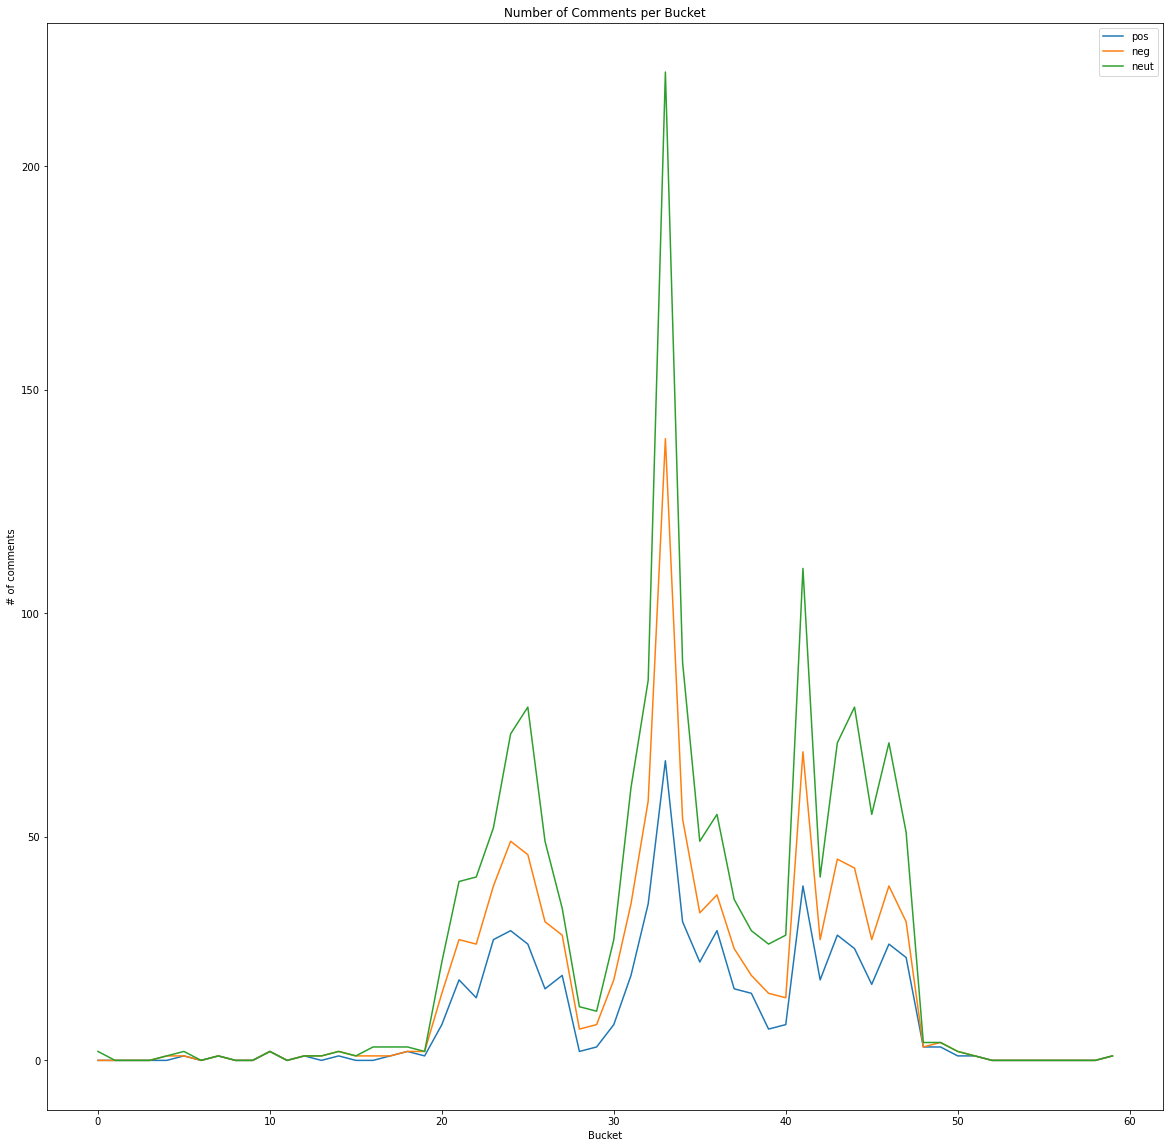

In [35]:
plt.plot(np.arange(0, first_n, 1), sentiment['pos'], label='pos')
plt.plot(np.arange(0, first_n, 1), np.add(sentiment['pos'],sentiment['neg']), label='neg')
plt.plot(np.arange(0, first_n, 1), np.add(sentiment['neut'], np.add(sentiment['pos'],sentiment['neg'])), label='neut')

plt.xlabel("Bucket")
plt.ylabel("# of comments")
plt.title("Number of Comments per Bucket")
plt.legend()
plt.show()

[]

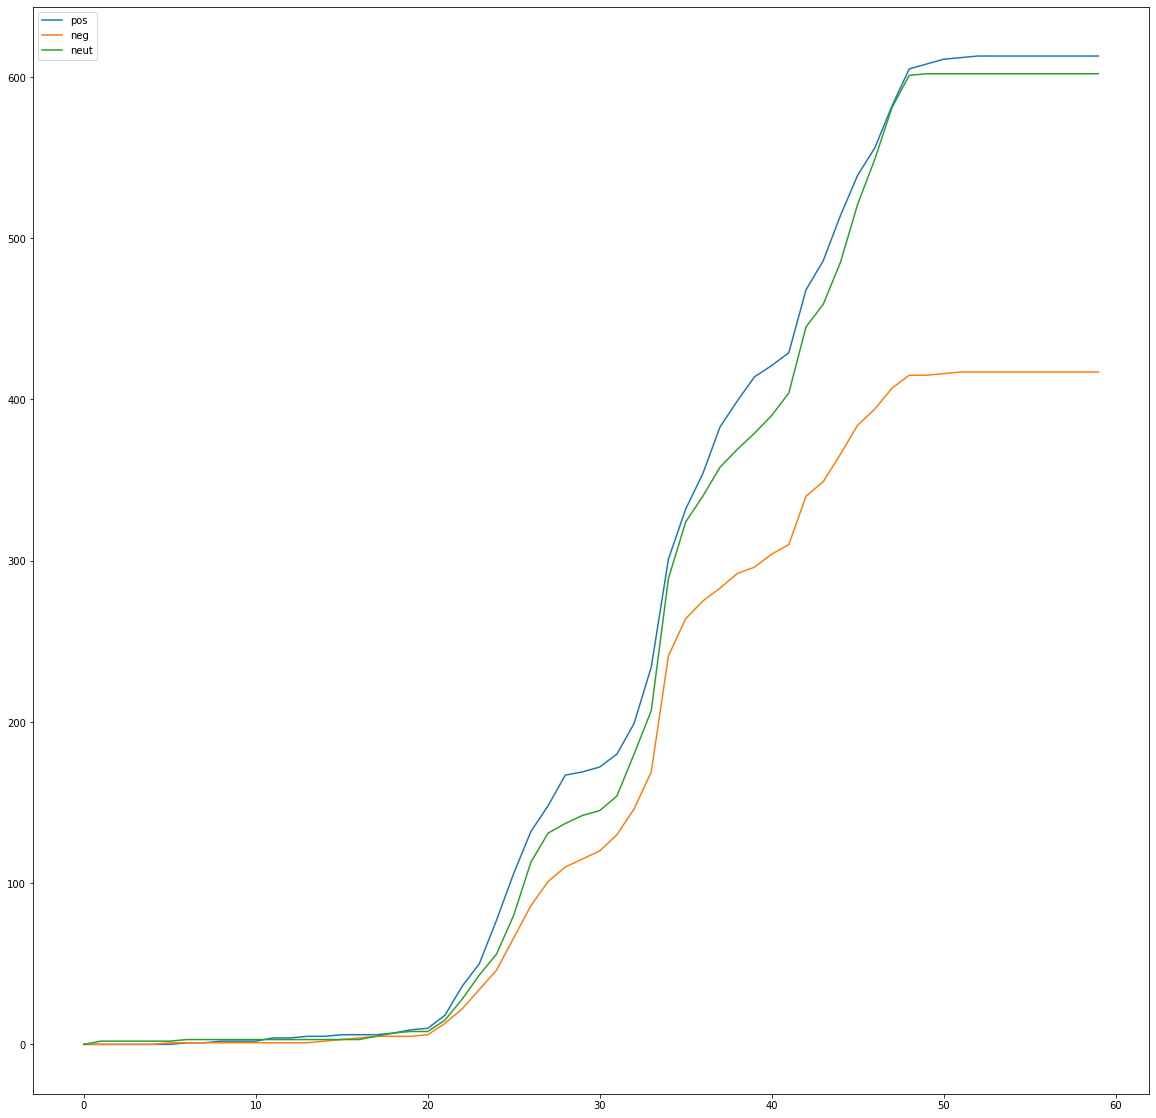

In [38]:
# number of comments as night progressed
sum_line = {'neg':[],'pos':[],'neut':[]}
for i in range(buckets):
    for s in types:
        sum_line[s].append(sum(sentiment[s][:i]))

plt.plot(np.arange(0, first_n, 1), sum_line['pos'][:first_n], label="pos")
plt.plot(np.arange(0, first_n, 1), sum_line['neg'][:first_n], label="neg")
plt.plot(np.arange(0, first_n, 1), sum_line['neut'][:first_n], label="neut")

plt.legend()
plt.plot()